<a href="https://colab.research.google.com/github/joaocarvoli/MachineLearning-course/blob/main/Exercises/06_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 06
## In this exercise We'll work with validations, like the holdout, cross-validation, pipeline, and grid search CV.


---

## The dataset that we'll use is: [`Pima Indians Diabetes Database`](https://data.world/data-society/pima-indians-diabetes-database).



### 1 - *Imports:*

In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Dataset
df = pd.read_csv('/content/drive/MyDrive/data-sets/diabetes/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2 - *Validation types:*  

In [3]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [4]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [5]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

### `Holdout`

#### - Normal split and shuffle

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 29)
set_holdout = pd.concat([X_train, y_train], axis = 1)
X_train_hold, X_test_hold, y_train_hold, y_test_hold = train_test_split(set_holdout.iloc[:,:-1], set_holdout.iloc[:,-1], test_size = 0.3 , random_state = 29)

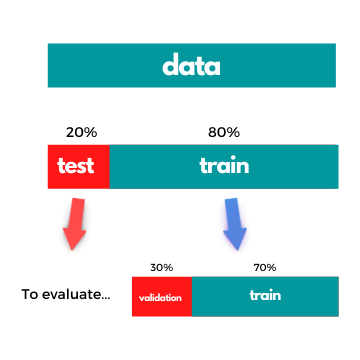

In [7]:
scalers = ['no scaler', 'minmax', 'std']
knn_hold = {'neighbor':[], 'F1 score':[], 'scaler':[]}
neighbors = [3,5,7,9,11]


for i in neighbors:
    for sca in scalers:
        knn = KNeighborsClassifier(n_neighbors = i)

        if sca == 'std':
            scaler = StandardScaler().fit(X_train_hold)
            X_train_transformed = scaler.transform(X_train_hold)

            knn = knn.fit(X_train_transformed, y_train_hold)

            X_test_transformed = scaler.transform(X_test_hold)
            pred = knn.predict(X_test_transformed)
            score = f1_score(y_test_hold, pred)

        elif sca == 'minmax':
            scaler = MinMaxScaler().fit(X_train_hold)
            X_train_transformed = scaler.transform(X_train_hold)

            knn = knn.fit(X_train_transformed, y_train_hold)

            X_test_transformed = scaler.transform(X_test_hold)
            pred = knn.predict(X_test_transformed)
            score = f1_score(y_test_hold, pred)


        else:
            knn.fit(X_train_hold, y_train_hold)
            pred = knn.predict(X_test_hold)
            score = f1_score(y_test_hold, pred)

        knn_hold['F1 score'].append(score)
        knn_hold['neighbor'].append(i)
        knn_hold['scaler'].append(sca)


knn_hold = pd.DataFrame.from_dict(knn_hold)
knn_hold.sort_values(by = 'F1 score', ascending=False)

,neighbor,F1 score,scaler
9,9,0.656000,no scaler
12,11,0.639344,no scaler
0,3,0.637037,no scaler
6,7,0.625954,no scaler
5,5,0.603175,std
3,5,0.600000,no scaler
1,3,0.592000,minmax
4,5,0.592000,minmax
2,3,0.585366,std
8,7,0.573770,std


### *Choosing the better result in the above algorithm and applying it below with all data!*

In [8]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
score = f1_score(y_test, pred)
score

0.5434782608695652

### `Cross Validation`

In [9]:
knn_cross_r = {'neighbor':[], 'score':[], 'scaler':[]}
folds = 5

for i in neighbors:
    for scaler in scalers:
        knn_cross = KNeighborsClassifier(n_neighbors = i, weights='distance')

        if scaler == 'minmax':
            clf = make_pipeline(MinMaxScaler(), knn_cross)
            score = cross_val_score(clf, X_train, y_train, cv=folds, scoring="f1", n_jobs = -1)

        elif scaler == 'std':
            clf = make_pipeline(StandardScaler(), knn_cross)
            score = cross_val_score(clf, X_train, y_train, cv=folds, scoring="f1", n_jobs = -1)

        else:
            score = cross_val_score(knn_cross, X_train, y_train, cv=folds, scoring="f1", n_jobs = -1)
            score = np.mean(score)
        

        score = np.mean(score)
        knn_cross_r['neighbor'].append(i)
        knn_cross_r['score'].append(score)
        knn_cross_r['scaler'].append(scaler)

knn_cross_r = pd.DataFrame.from_dict(knn_cross_r)
knn_cross_r.sort_values(by = 'score', ascending=False)

,neighbor,score,scaler
5,5,0.613972,std
4,5,0.596215,minmax
2,3,0.593722,std
11,9,0.593641,std
9,9,0.591725,no scaler
8,7,0.588014,std
10,9,0.587435,minmax
12,11,0.583526,no scaler
6,7,0.580367,no scaler
7,7,0.580270,minmax


### *Choosing the better result in the above algorithm and applying it below with all data!*

In [10]:
knn_cross = KNeighborsClassifier(n_neighbors = 5, weights='distance')
clf = make_pipeline(MinMaxScaler(), knn_cross)
score = cross_val_score(clf, X, y, cv=folds, scoring="f1", n_jobs = -1)
np.mean(score)

0.620412410432282

### `Grid Search CV`



In [11]:
parameters = {'n_neighbors':[3,5,7,9,11], 'weights':('uniform', 'distance'), 'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'p':[1,2]}
knn_grid = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn_grid,  param_grid = parameters, scoring = 'f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [12]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002598,0.000148,0.007148,0.000182,auto,3,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 1...",0.538462,0.476190,0.517647,0.659794,0.632911,0.565001,0.069902,65
1,0.002609,0.000241,0.003794,0.000525,auto,3,1,distance,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 1...",0.545455,0.419753,0.511628,0.659794,0.615385,0.550403,0.083410,77
2,0.002604,0.000182,0.007385,0.000709,auto,3,2,uniform,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2...",0.564103,0.500000,0.561798,0.580645,0.625000,0.566309,0.040180,61
3,0.002892,0.000414,0.003206,0.000101,auto,3,2,distance,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2...",0.556962,0.465116,0.561798,0.574468,0.625000,0.556669,0.051758,73
4,0.002887,0.000517,0.008883,0.001783,auto,5,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1...",0.597403,0.481013,0.550000,0.695652,0.692308,0.603275,0.082802,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.002637,0.000125,0.005377,0.000329,brute,9,2,distance,"{'algorithm': 'brute', 'n_neighbors': 9, 'p': ...",0.585366,0.530120,0.588235,0.588235,0.666667,0.591725,0.043534,29
76,0.002870,0.000184,0.011774,0.001638,brute,11,1,uniform,"{'algorithm': 'brute', 'n_neighbors': 11, 'p':...",0.605263,0.543210,0.592593,0.592593,0.708861,0.608504,0.054501,17
77,0.003555,0.001020,0.005746,0.000781,brute,11,1,distance,"{'algorithm': 'brute', 'n_neighbors': 11, 'p':...",0.613333,0.518519,0.585366,0.651163,0.700000,0.613676,0.061178,9
78,0.002649,0.000430,0.011784,0.001403,brute,11,2,uniform,"{'algorithm': 'brute', 'n_neighbors': 11, 'p':...",0.578947,0.592593,0.543210,0.641975,0.691358,0.609617,0.051709,13


In [13]:
pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']].sort_values(by = 'rank_test_score')

,params,rank_test_score,mean_test_score
32,"{'algorithm': 'ball_tree', 'n_neighbors': 9, '...",1,0.623592
72,"{'algorithm': 'brute', 'n_neighbors': 9, 'p': ...",1,0.623592
52,"{'algorithm': 'kd_tree', 'n_neighbors': 9, 'p'...",1,0.623592
12,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1...",1,0.623592
53,"{'algorithm': 'kd_tree', 'n_neighbors': 9, 'p'...",5,0.622717
...,...,...,...
63,"{'algorithm': 'brute', 'n_neighbors': 3, 'p': ...",73,0.556669
21,"{'algorithm': 'ball_tree', 'n_neighbors': 3, '...",77,0.550403
41,"{'algorithm': 'kd_tree', 'n_neighbors': 3, 'p'...",77,0.550403
1,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 1...",77,0.550403


In [14]:
grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

In [15]:
grid.best_score_

0.6235917785917786

### *Testing with scaled data:*

In [16]:
std_scaler = StandardScaler().fit(X_train)
X_train_transformed = std_scaler.transform(X_train)

parameters = {'n_neighbors':[3,5,7,9,11], 'weights':('uniform', 'distance'), 'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'p':[1,2]}
knn_grid = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn_grid,  param_grid = parameters, scoring = 'f1')
grid.fit(X_train_transformed, y_train)

print(grid.best_params_)
print(grid.best_score_)


minmax_scaler = MinMaxScaler().fit(X_train)
X_train_transformed = minmax_scaler.transform(X_train)

parameters = {'n_neighbors':[3,5,7,9,11], 'weights':('uniform', 'distance'), 'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'p':[1,2]}
knn_grid = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn_grid,  param_grid = parameters, scoring = 'f1')
grid.fit(X_train_transformed, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.6170494769416343
{'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.6010218627501224


### *When we tried to use the scalers, the results are worse!*

### *Choosing the better result in the above algorithm and applying it below with all data!*

In [17]:
knn_grid = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 9, weights = 'uniform', p = 1)
knn_grid.fit(X_train, y_train)
knn_grig_predict = knn_grid.predict(X_test)
f1_score(y_test, knn_grig_predict)

0.6292134831460674